In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
print(thailandmap.unary_union.bounds)
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(97.34335847100004, 5.613037873000053, 105.63696451800007, 20.46507381500004)


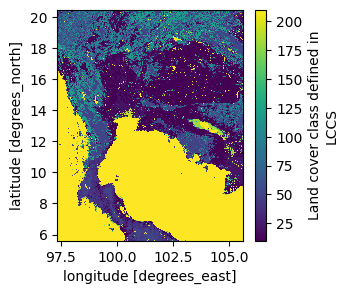

In [3]:
## Then, I acquire data according to the boundary ##
xr_landuse = xr.open_dataset("Data//C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1-001.nc")
xr_landuse = xr_landuse.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
xr_landuse = xr_landuse.reindex(lat=xr_landuse.lat[::-1])
xr_landuse = xr_landuse.sel(time = '2020-01-01')
xr_landuse = xr_landuse.drop_vars('time')
lccs_resolution = 300## meters

fig, ax = plt.subplots(figsize=(3,3))
xr_landuse['lccs_class'].plot(ax = ax,zorder = 0)

In [6]:
## Here, I assign scores to the land according to the literature ##

## Shrubs and Grassland
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_BGEC'])
## Natural Reserve
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_BGEC'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_BGEC'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_BGEC'])

## Shrubs and Grassland
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_Biomass'])
## Natural Reserve
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_Biomass'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Biomass'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Biomass'])

## Bare area and Grassland
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([200,201,202,110,130])),3,0) 
## Agriculture
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([10,11,12,20,30,40])),2,xr_landuse['SI_Solar'])
## Short vegetation and shrubs
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([120,121,122,140,150,151,152,153,180])),1,xr_landuse['SI_Solar'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Solar'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Solar'])

## Bare area and Grassland
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([200,201,202,110,130])),3,0) 
## Agriculture
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([10,11,12,20,30,40])),2,xr_landuse['SI_Wind'])
## Short vegetation and shrubs
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([120,121,122,140,150,151,152,153,180])),1,xr_landuse['SI_Wind'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_Wind'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_Wind'])

## Shrubs and Grassland
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_BGWW'])
## Natural Reserve
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_BGWW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_BGWW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_BGWW'])

## Shrubs and Grassland
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_MSW'])
## Natural Reserve
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_MSW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_MSW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_MSW'])

## Shrubs and Grassland
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([110,130,120,121,122,200,201,202])),3,0) 
## Short vegetation and agriculture 
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([140,150,151,152,153,10,11,12,20,30,40])),2,xr_landuse['SI_IEW'])
## Natural Reserve
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([180])),1,xr_landuse['SI_IEW'])
## Tall vegetation, forest,settlement area and water 
xr_landuse['SI_IEW'] = xr.where((xr_landuse['lccs_class'].isin([50,60,61,62,70,71,72,80,81,82,90,100,160,170,190,210])),0,xr_landuse['SI_IEW'])

print(xr_landuse)

<xarray.Dataset>
Dimensions:              (lat: 5346, lon: 2985, bounds: 2)
Coordinates:
  * lat                  (lat) float64 5.615 5.618 5.621 ... 20.46 20.46 20.46
  * lon                  (lon) float64 97.35 97.35 97.35 ... 105.6 105.6 105.6
Dimensions without coordinates: bounds
Data variables: (12/16)
    lccs_class           (lat, lon) uint8 210 210 210 210 210 ... 30 40 50 50 50
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) uint16 ...
    change_count         (lat, lon) uint8 ...
    crs                  int32 ...
    ...                   ...
    SI_Biomass           (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_Solar             (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_Wind              (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_BGWW              (lat, lon) int32 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 0 0 0
    SI_MSW               (lat, lon)

In [13]:
df_landuse_suitability_index = xr_landuse.to_dataframe()
df_landuse_suitability_index.reset_index(inplace=True)
print('before = ',df_landuse_suitability_index.columns)

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns=[
    'processed_flag',
    'current_pixel_state',
    'observation_count',
    'change_count',
    'crs',
    'lat_bounds',
    'lon_bounds',
    'time_bounds',
    'bounds'
    ])

df_landuse_suitability_index = gpd.GeoDataFrame(df_landuse_suitability_index, geometry =gpd.points_from_xy(df_landuse_suitability_index['lon'],df_landuse_suitability_index['lat']))
df_landuse_suitability_index.crs = {'init': 'epsg:4326'}

print('after = ',df_landuse_suitability_index.columns)


before =  Index(['lat', 'lon', 'bounds', 'lccs_class', 'processed_flag',
       'current_pixel_state', 'observation_count', 'change_count', 'crs',
       'lat_bounds', 'lon_bounds', 'time_bounds', 'SI_BGEC', 'SI_Biomass',
       'SI_Solar', 'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW'],
      dtype='object')
after =  Index(['lat', 'lon', 'lccs_class', 'SI_BGEC', 'SI_Biomass', 'SI_Solar',
       'SI_Wind', 'SI_BGWW', 'SI_MSW', 'SI_IEW', 'geometry'],
      dtype='object')


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [16]:
## Next, I filter out area that are not in Thailand ## 

## Acquire polygon containing boudary of Thailand
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
th = world.loc[world['name'] == 'Thailand'] # get Thailand row
boundaries = th['geometry'] # get Thailand geometry
boundaries.crs = {'init': 'epsg:4326'}
boundaries = boundaries.geometry.unary_union

df_landuse_suitability_index['aux'] = 1
df_landuse_suitability_index['aux'].loc[~df_landuse_suitability_index.within(boundaries)] = 0

df_landuse_suitability_index['SI_BGEC'] = df_landuse_suitability_index['SI_BGEC'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Biomass'] = df_landuse_suitability_index['SI_Biomass'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Solar'] = df_landuse_suitability_index['SI_Solar'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_Wind'] = df_landuse_suitability_index['SI_Wind'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_BGWW'] = df_landuse_suitability_index['SI_BGWW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_MSW'] = df_landuse_suitability_index['SI_MSW'] * df_landuse_suitability_index['aux']
df_landuse_suitability_index['SI_IEW'] = df_landuse_suitability_index['SI_IEW'] * df_landuse_suitability_index['aux']

df_landuse_suitability_index = df_landuse_suitability_index.drop(columns='geometry')
df_landuse_suitability_index = df_landuse_suitability_index.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

print(xr_landuse_suitability_index)

C:\Users\EGAT\AppData\Local\Temp\ipykernel_21436\2665862210.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world_filepath = gpd.datasets.get_path('naturalearth_lowres')
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_21436\2665862210.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray

In [18]:
print(df_landuse_suitability_index)
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_landuse_suitability_index)

                      lccs_class  SI_BGEC  SI_Biomass  SI_Solar  SI_Wind  \
lat       lon                                                              
5.615278  97.345833          210        0           0         0        0   
          97.345833          210        0           0         0        0   
          97.348611          210        0           0         0        0   
          97.348611          210        0           0         0        0   
          97.351389          210        0           0         0        0   
...                          ...      ...         ...       ...      ...   
20.462500 105.629167          50        0           0         0        0   
          105.631944          50        0           0         0        0   
          105.631944          50        0           0         0        0   
          105.634722          50        0           0         0        0   
          105.634722          50        0           0         0        0   

           

ValueError: cannot convert a DataFrame with a non-unique MultiIndex into xarray